# Assignment 1 | Machine, Data and Learning

## Question 2
\
<span style='font-family:serif; font-size:18px'>
This question aims at exploring and calculating the *bias* and *variance* of different models.
    
</span><span style='font-family:serif; font-size:18px'>
**Bias** is the difference between the average prediction of our model and the actual value we are trying to predict. A model with a *high bias* pays little attention to the training data and oversimplifies the function it is trying to predict. Thus it ends up with a high error on both the training and test data.
</span>

<center>$Bias = E[\hat{f}(x)] - f(x)$</center>

<span style='font-family:serif; font-size:18px'>
    
**Variance** is the variability of a model prediction for a given data point. It captures how much the model predictions for a given point vary between different realizations of the model.
</span>

<center>$Variance = E[(\hat{f}(x) - E[\hat{f}(x)])^2]$</center>

<span style='font-family:serif; font-size:18px'>
Here, we train 9 different models, each of which is trained separately on 20 different datasets. The 20 realizations of each model are used to calculate the bias and variance of that model on each point of a test set.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn import linear_model
import pickle
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from numpy import cov
from tabulate import tabulate
%matplotlib inline

### Dataset Preprocessing
<span style='font-family:serif; font-size:18px'>
    In this section, we load and visualise the dataset, ensuring that it is in a form that can be used for training the model.
</span>

In [2]:
with open('./Q2_data/X_train.pkl', 'rb') as f:
    train_X = pickle.load(f)

In [3]:
with open('./Q2_data/Y_train.pkl', 'rb') as f:
    train_Y = pickle.load(f)

In [4]:
with open('./Q2_data/X_test.pkl', 'rb') as f:
    test_X = pickle.load(f)

In [5]:
with open('./Q2_data/Fx_test.pkl', 'rb') as f:
    test_Y = pickle.load(f)

In [6]:
print(train_X.shape)
print(train_Y.shape)

(20, 400)
(20, 400)


In [7]:
print(train_X)

[[ 39.18236666  -7.08833508 -39.80170787 ... -39.91722818 -32.1922517
  -34.59690847]
 [  3.65397031 -23.00911309  30.09446289 ...  36.35403106   8.9512678
   22.57524484]
 [ 33.67587032 -19.08946213  18.09819893 ...  41.5257231   44.8411174
  -17.78096981]
 ...
 [ 44.49194225 -45.57639101  46.74878519 ... -26.08145893 -42.46265146
    2.37850948]
 [-10.09926802  30.83303774   5.34475387 ...  -2.19280553 -11.05173998
  -25.4291418 ]
 [ 46.30665334  11.60395221  -2.90249351 ...  39.35145933  12.8210855
  -28.09216372]]


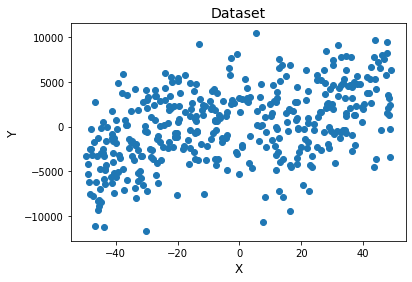

In [8]:
plt.scatter(train_X[0],train_Y[0])
plt.xlabel('X',fontsize = 12)
plt.ylabel('Y',fontsize = 12)
plt.title('Dataset', fontsize = 14)
plt.show()

### Training
<span style='font-family:serif; font-size:18px'>
In this section, we train the models on the training dataset.
</span>
<span style='font-family:serif; font-size:18px'>
In the following cell, we train each model (i.e. polynomial of a particular degree) 20 times, once on each partition. The performance metrics of the model are computed by calculating its bias and variance on each data point (in the test set) across the 20 realizations of the model. The mean bias (or variance) of the model is then the mean of the bias (or variance) values calculated for each data point (in the test set).

The outer loop iterates over the 9 different models (i.e. polynomials of different degrees), while the inner loop iterates over the 20 different realizations of the model in consideration. Here, the model is trained on one of the partitions of the training set, and then tested on the test set. The code uses vectorization by invoking `numpy`'s functions instead of loops, which takes advantage of vector hardware/GPUs. The predictions of the model are then stored. After all 20 realizations have been trained and tested for a particular model, we find the average difference in predicted and actual values for each data point, averaged across the 20 realizations, which gives the bias of the model for each data point. Similarly, variance of the model is calculated for each data point by using the formula mentioned earlier. The bias (or variance) of the model is then the average of the bias (or variance) for each data point.
    
This process is repeated for each of the 20 different models.
</span>

+----------+------------------+----------------+------------+
|   Degree |           Errors |   Squared Bias |   Variance |
|----------+------------------+----------------+------------|
|        1 |      1.06977e+06 |      999228    |    70545.5 |
|        2 |      1.08049e+06 |      954619    |   125871   |
|        3 | 159463           |        9389.73 |   150074   |
|        4 | 223143           |       10907.3  |   212236   |
|        5 | 285728           |        9339.19 |   276388   |
|        6 | 327112           |       10248.6  |   316863   |
|        7 | 367846           |       10335.3  |   357511   |
|        8 | 414436           |       10149.4  |   404287   |
|        9 | 469948           |       10815.5  |   459132   |
+----------+------------------+----------------+------------+


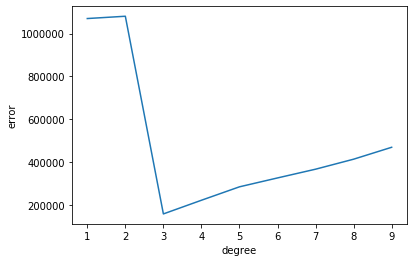

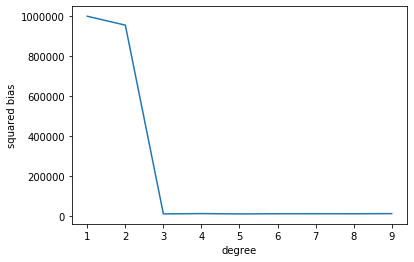

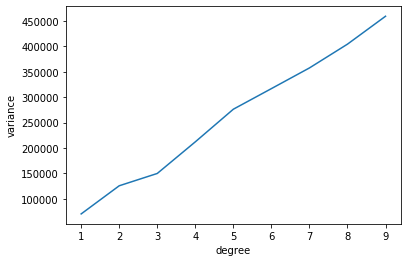

[ 0.00000000e+00  0.00000000e+00  2.91038305e-11  2.91038305e-11
  0.00000000e+00  0.00000000e+00  0.00000000e+00  5.82076609e-11
 -1.16415322e-10]


In [9]:
errors = list()
bias_square = list()
variance = list()
# for the test figure
test_fig, test_axs = plt.subplots(3, 3, figsize=(30, 30))

for currDeg in range(1,10):
    predict = list()
    diffs = list()
    error = list()
    poly = PolynomialFeatures(degree = currDeg)
    curr_test_X = poly.fit_transform(test_X.reshape(-1,1))
    # loop over all the 10 partitions to create 10 different models
    for chunk in range(20):
        curr_train_X = poly.fit_transform(train_X[chunk].reshape(-1,1))
        # get the regressor now
        regressor = linear_model.LinearRegression()
        regressor.fit(curr_train_X,train_Y[chunk])
        
        # now test it
        prediction = regressor.predict(curr_test_X)
        
        # fill the lists
        diffs.append(prediction - test_Y)
        predict.append(prediction)
        error.append(mean_squared_error(test_Y,prediction))
        
        if chunk == 0:
            # make a plot for this model using the zeroeth chunk
            test_axs.flat[currDeg-1].scatter(test_X, test_Y, label='Actual Data')
            test_axs.flat[currDeg-1].scatter(test_X, prediction, label='Predicted Data')
            test_axs.flat[currDeg-1].set(xlabel='x', ylabel='y')
            test_axs.flat[currDeg-1].set_title('Degree ' + str(currDeg), fontweight='bold', size=20)
            test_axs.flat[currDeg-1].tick_params(labelsize=22)
            test_handles, test_labels = test_axs.flat[currDeg-1].get_legend_handles_labels()
        
        # calculate bias = E(f' - f) and variance = E[(f' - E[f'])^2] for each point accross models
    errors.append(np.mean(error))
    diffs = np.array(diffs)
    diffs = np.transpose(diffs)
    predict = np.array(predict)
    curr_bias = np.mean(np.mean(diffs,1)**2)

    bias_square.append(curr_bias)
    variance.append(np.mean((predict - np.mean(predict,0))**2))

# calculate the required list to print the graph for bias and variance
errors = np.array(errors)
bias_square = np.array(bias_square)
variance = np.array(variance)

table_dict = {
    'Degree': [i for i in range(1, 10)],
    'Errors': errors,
    'Squared Bias': bias_square,
    'Variance': variance
}

print(tabulate(table_dict, headers='keys', tablefmt='psql'))

plt.close()

plt.figure(10)
plt.plot(range(1,10),errors)
plt.xlabel('degree')
plt.ylabel('error')
plt.show(10)

plt.figure(11)
plt.plot(range(1,10),bias_square)
plt.xlabel('degree')
plt.ylabel('squared bias')
plt.show(11)

plt.figure(12)
plt.plot(range(1,10),variance)
plt.xlabel('degree')
plt.ylabel('variance')
plt.show(12)

# this value corresponds to the variance of the noise added to the original data
print(errors - (bias_square+variance))

### Analysis
<span style='font-family:serif; font-size:18px'>
Now that we have the plots for the squared bias and variance of each model, we can analyse and compare their performance.
    
#### Bias
As the degree of the polynomial hypothesis increases, the function becomes more flexible, allowing it to better mould itself to fit the training dataset. Hence, the error on the test dataset also decreases. Because the bias (the average difference between the predicted and actual values) effectively captures this error, we see a steadily deceasing trend in the bias values with an increase in degree of the hypothesis function.
    
The error starts increasing after polynomial of degree 3 which hints at the fact that the data is best modelled by a degree 3 hypothesis, and a further increase in degree of the hypothesis would be frivolous.
    
#### Variance
The variance of the models shows a general increase with an increase in the degree of the hypothesis. This is because as the degree of the polynomial increases and it becomes more flexible, it also becomes more susceptible to minor variations in the training dataset. Hence, each time the model is trained, the increased flexibility of the higher degree polynomials causes the coefficients to turn out significantly different due to differences in the training set. Hence, the high variance on the test dataset.
    
The squared bias decreases drastically in transition from degree 2 to degree 3 polynomial. This is because of the nature of the test data, It looks very similar to a cubic equation. That is the reason that all the higher polynomial fit the curve well and the bias remains almost the same.
</span>

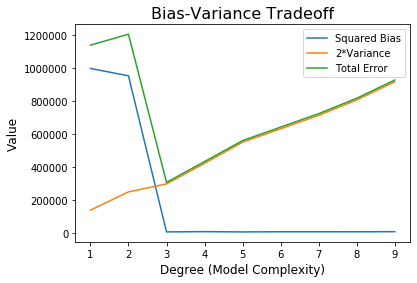

In [10]:
plt.figure(13)
plt.plot(range(1, 10), bias_square, label='Squared Bias')
plt.plot(range(1, 10), variance*2 , label='2*Variance')
plt.plot(range(1, 10), variance*2+ bias_square, label='Total Error')
plt.xlabel('Degree (Model Complexity)', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Bias-Variance Tradeoff', fontsize=16)
plt.legend()
plt.show(13)

<span style='font-family:serif; font-size:18px'>
This plot shows the squared bias and variance plotted on the same graph to visualize the Bias-Variance Tradeoff. Please note that variance has been scaled to 2 times the original to make the values of the same order.
</span>

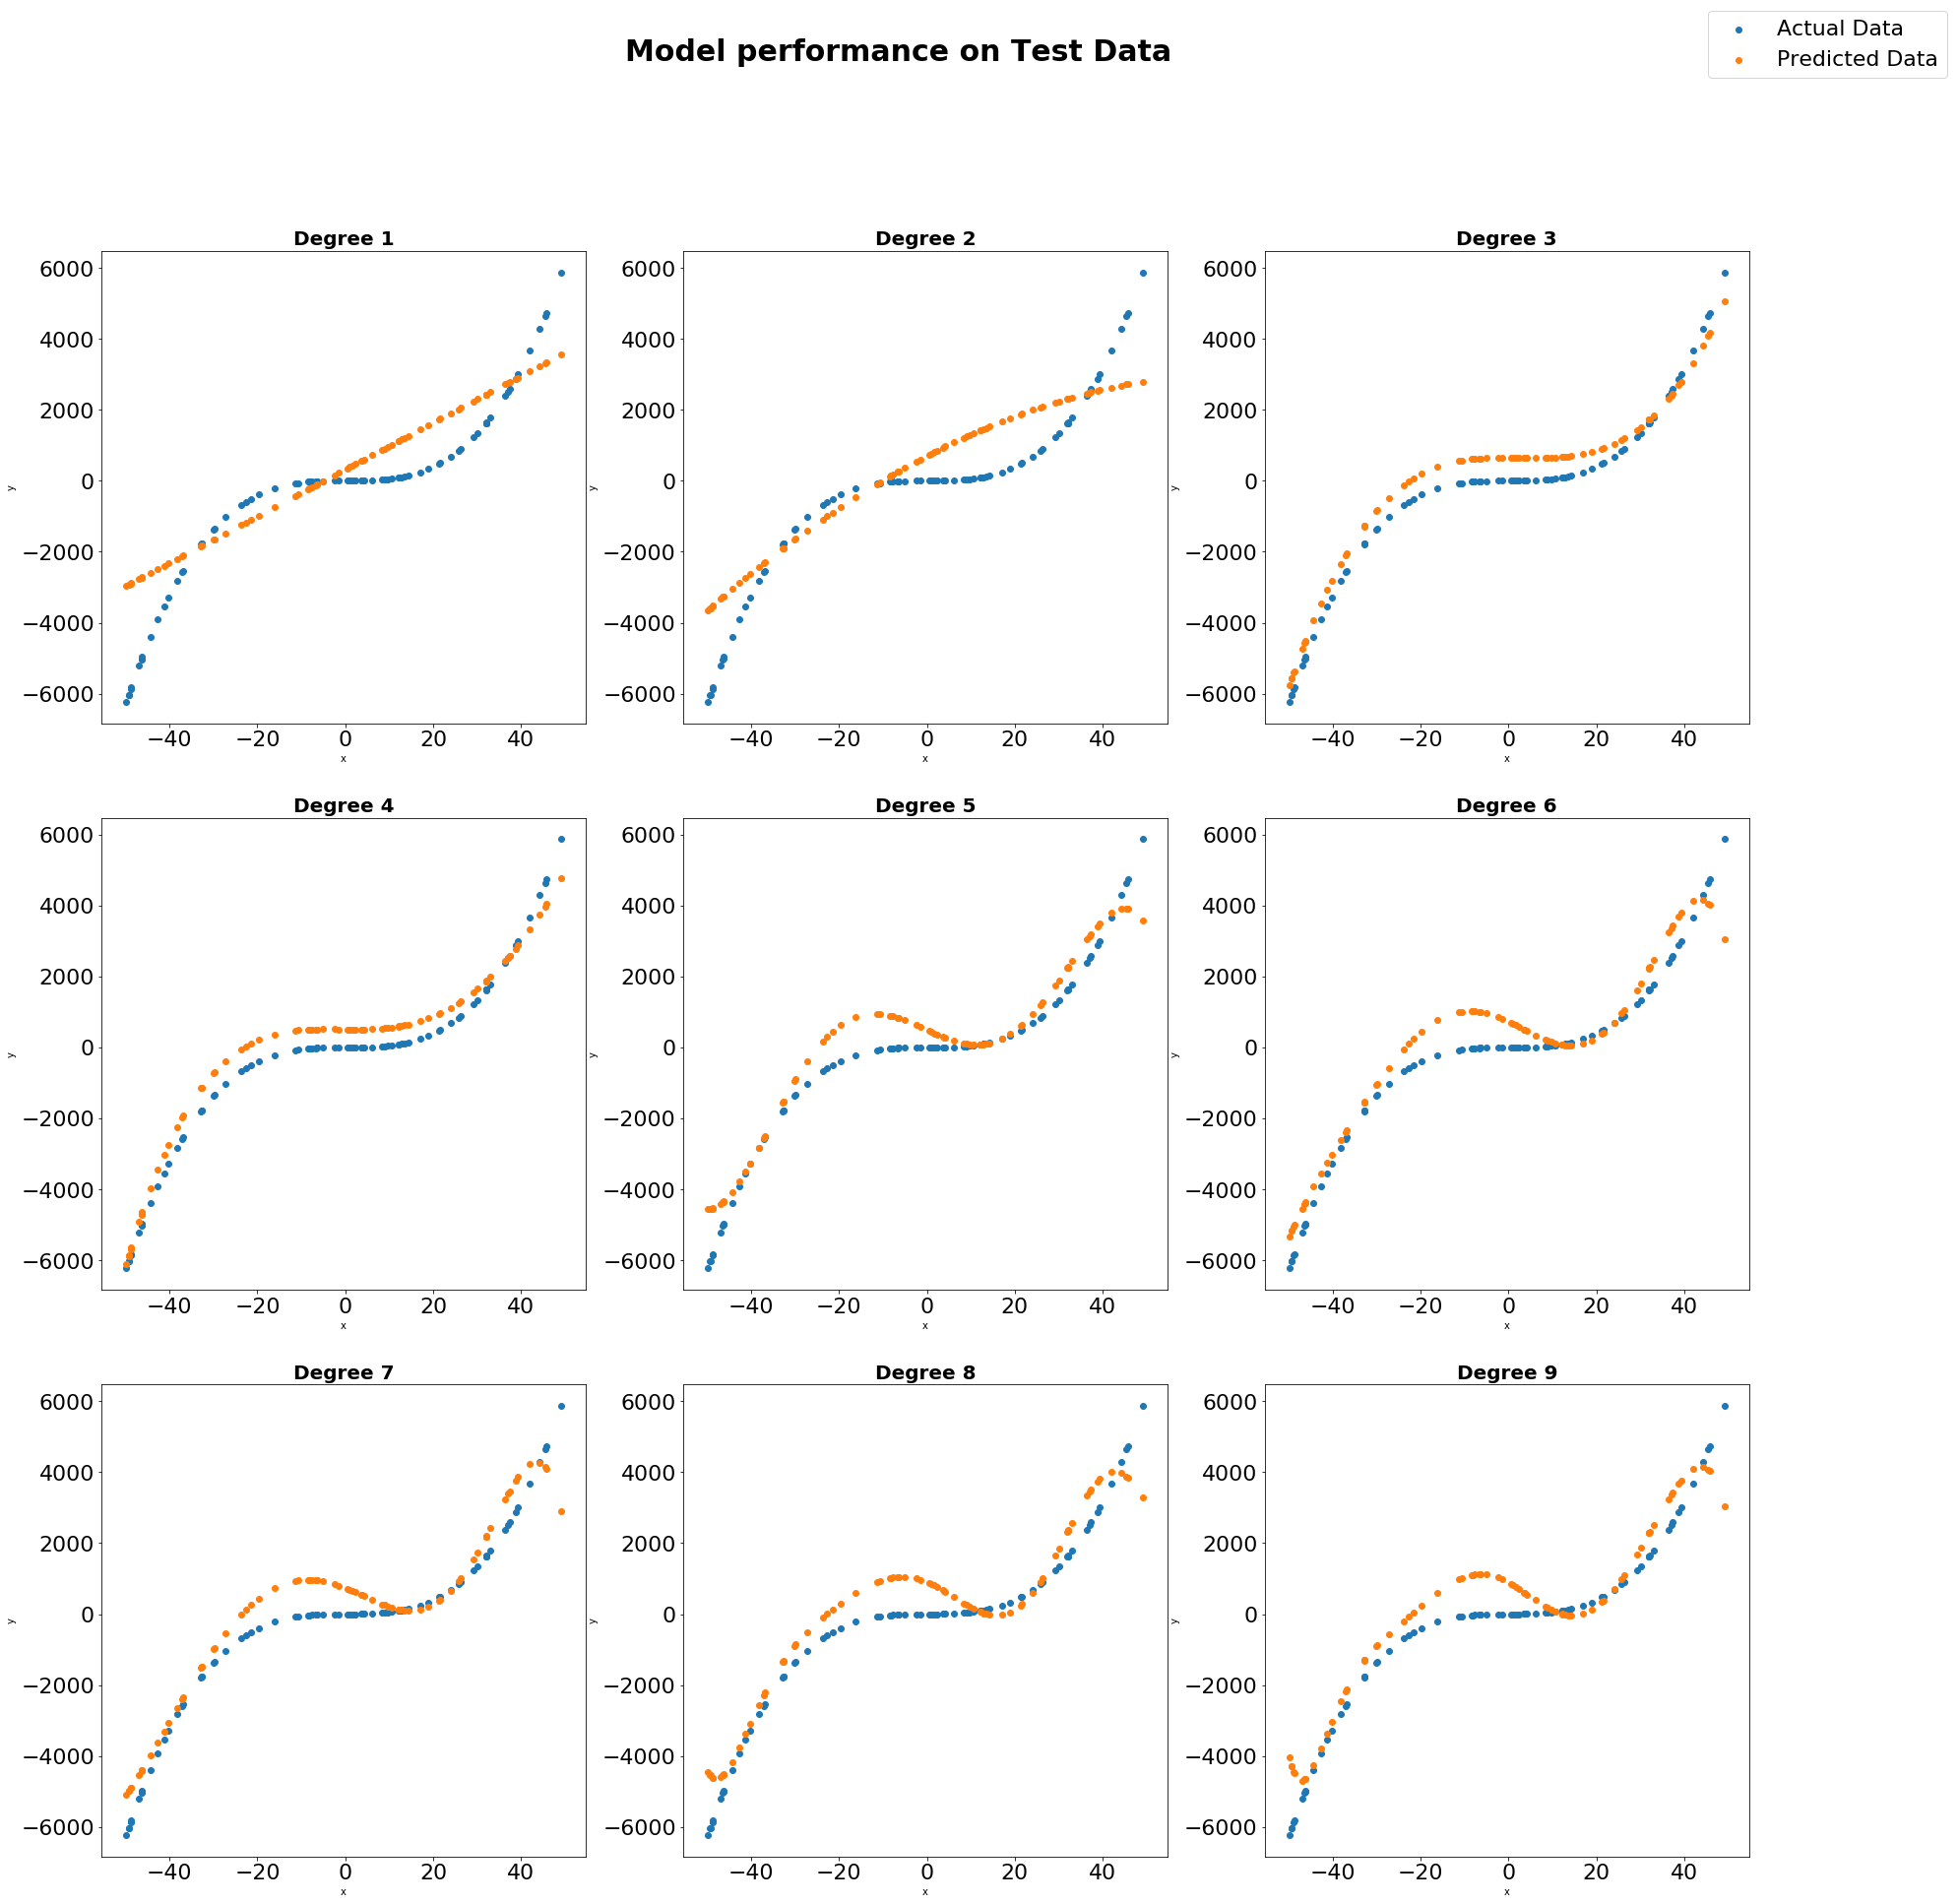

In [11]:
test_fig.legend(test_handles, test_labels, loc='upper right', fontsize=22)
test_fig.suptitle('Model performance on Test Data', fontweight='bold', size=30)
test_fig

<span style='font-family:serif; font-size:18px'>
These plots show the performance of each of the 9 models on the test dataset. Because we have 20 realizations of each 
model, we have just used the first one (since each is trained on a random partition of the dataset).

These plots clearly show the trends that have been described above. As the degree of the hypothesis increases, the 
output more closely follows the actual values - indicating a lower error, or bias on the test (as well as training) 
dataset. However, the error starts increasing once the degree crosses 3 - which indicates that the optimal 
degree of the hypothesis would be around 3.

One can also notice how minor variations in the dataset affect the higher degree polynomials. Although the plots do 
not explicitly show it, this can easily be extrapolated to indicate a high variance in those models.
</span>

### Conclusion

<span style='font-family:serif; font-size:18px'>
    
From the graphs, it is evident that an increase in degree beyond 6 does not bring much benefit in terms of bias, but just increases the variance for the worse. Because degree 4 has the least variance amongst degrees 4 to 6, it might be the best suited model for this case.
    
</span>